In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, \
    precision_recall_curve, auc
from sklearn.preprocessing.label import LabelBinarizer
from models import DeepSeaSNP, Conservation, SNPContext, MultiFeatures, EnhancerOneHot, \
    SubstitutionOneHot, DNase, Classifier, Regression
from cagi5_utils import get_breakpoint_df
from crossval import ChunkCV, PerElementOperator, CVOperator, df_cv_split
from utils import make_plots

## Load data

Read the training data with added conservation information.

In [2]:
df = pd.read_csv('data/cagi5_df.csv')
df.head()

,#Chrom,Pos,Ref,Alt,Value,Confidence,class,regulatory_element,phastCon,phyloP,GerpN,GerpRS
0,X,138612669,T,A,-0.17,0.07,0,release_F9,0.006,0.47,3.93,1.490
1,X,138612669,T,C,-0.26,0.24,-1,release_F9,0.006,0.47,3.93,1.490
2,X,138612669,T,G,0.34,0.05,0,release_F9,0.006,0.47,3.93,1.490
3,X,138612670,A,C,0.00,0.00,0,release_F9,0.008,0.47,3.93,0.337
4,X,138612670,A,G,0.22,0.20,1,release_F9,0.008,0.47,3.93,0.337


Split the training data into folds respecting the breakpoints.

In [3]:
breakpoint_df = pd.read_csv('data/cagi5_bkpt.csv')
nfolds = 5
fold_dict = df_cv_split(breakpoint_df, nfolds)
fold_dict

{'release_F9': [[4], [0], [3], [2], [1]],
 'release_GP1BB': [[2, 0], [3], [5], [1], [4]],
 'release_HBB': [[2], [1], [0], [], []],
 'release_HBG1': [[1], [0], [3], [2], []],
 'release_HNF4A': [[1], [3], [2], [0], []],
 'release_IRF4': [[2, 6], [1, 3], [5, 4], [0], [7]],
 'release_IRF6': [[7, 5], [1, 6], [0, 2], [3, 8], [4]],
 'release_LDLR': [[3], [1], [4], [2], [0]],
 'release_MSMB': [[7, 1], [6, 0], [8, 2], [3, 5], [4]],
 'release_MYCrs6983267': [[7, 3], [4, 1], [0, 2], [6, 8], [5]],
 'release_PKLR': [[3, 1], [7, 2], [0, 6], [5], [4]],
 'release_SORT1': [[7, 6], [0, 4], [3, 8], [2, 5], [1]],
 'release_TERT-GBM': [[1], [2], [3], [0], [4]],
 'release_TERT-HEK293T': [[3], [4], [0], [1], [2]],
 'release_ZFAND3': [[6, 0, 3], [1, 5], [4, 10], [2, 8], [9, 7]]}

## Create features

In [4]:
deepseadiffs = DeepSeaSNP(feattypes=['diff'])
dnase = DNase()
enhancer1hot = EnhancerOneHot()
snpcontext2 = SNPContext(context_size=2)
snpcontext4 = SNPContext(context_size=4)
conservation = Conservation()
deepE1h = MultiFeatures([deepseadiffs, enhancer1hot])
subst = SubstitutionOneHot()

## Predictive power

Test predictive power of each feature set separately

In [5]:
def test_features(features):
    cv_chunk = ChunkCV(df,
                       operator=PerElementOperator(CVOperator(
                           Regression,
                           model_kwargs={'features': features, 'model_name': 'xgb'})),
                       fold_dict=fold_dict)
    cv_regress = cv_chunk.get_cv_preds()
    (fpr, tpr, thresholds, auroc), (precision, recall, thresholds, auprc) = make_plots(cv_regress)
    return auroc, auprc

### DNase

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


(0.5896644525881815, 0.33290298502258564)

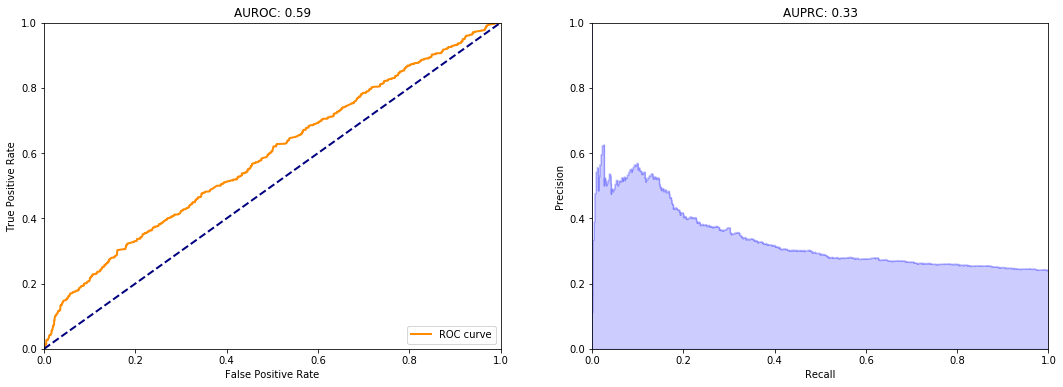

In [6]:
test_features(dnase)

### Reference/alternate subtitutions

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


(0.48230582277192446, 0.22124361048189783)

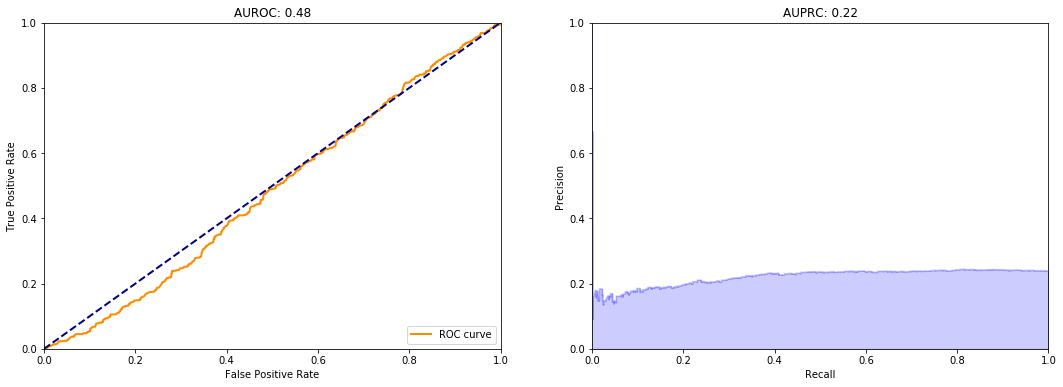

In [7]:
test_features(subst)

### SNP context

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


(0.50719880897847, 0.261601465524569)

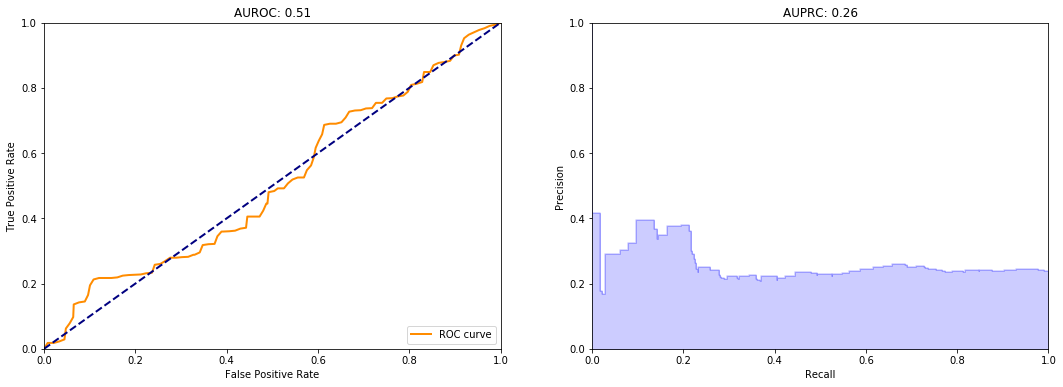

In [8]:
test_features(snpcontext2)

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


(0.4662262686415229, 0.23344351477443634)

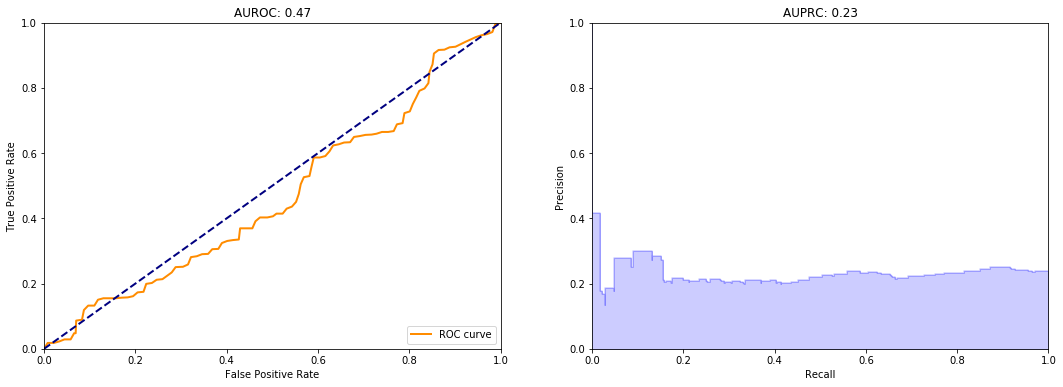

In [9]:
test_features(snpcontext4)

### Sequence conservation

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


(0.5847392731714767, 0.3006064170282501)

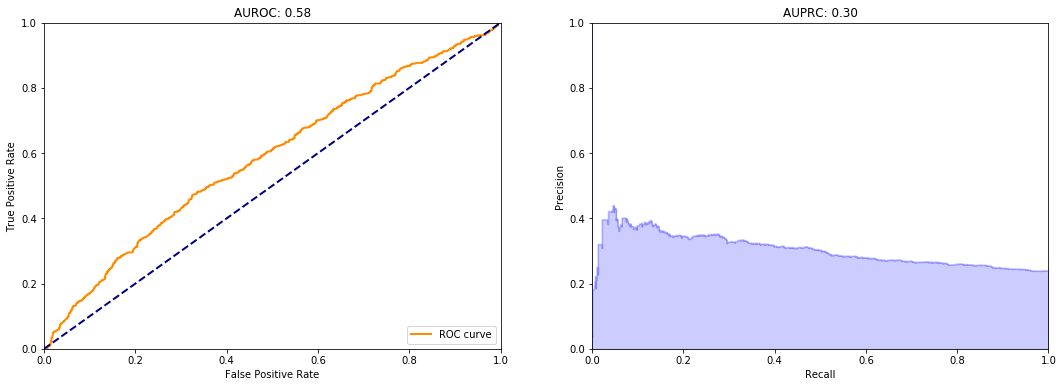

In [10]:
test_features(conservation)

### DeepSea differences

Getting predictions for fold 0
Getting predictions for fold 1
Getting predictions for fold 2
Getting predictions for fold 3
Getting predictions for fold 4


(0.6580292156563342, 0.4203501479934351)

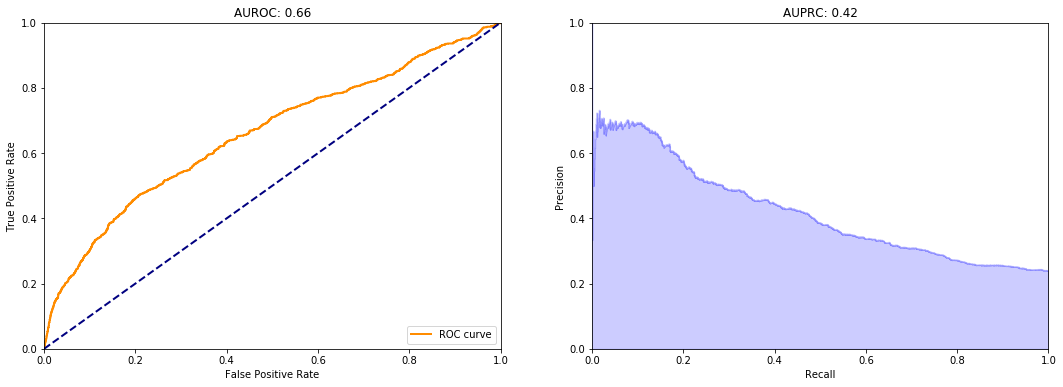

In [11]:
test_features(deepseadiffs)